> [SNN basic task](https://github.com/xjtulyc/SNN_basic_task)

> [snntorch](https://pypi.org/project/snntorch/)

> [SpikingJelly](https://spikingjelly.readthedocs.io/zh-cn/latest/index.html)

目前测试到不适配回归任务


In [1]:
import torch
import torch.nn as nn
inp_size = 3
out_size = 5
state = torch.zeros(1, out_size) # statew = torch.zeros(inp_size, out_size) # weightsthreshold = 0.6
x = torch.randn(1, inp_size) # input

In [18]:
class SNNLayer(nn.Module):
        def __init__(self, inp_size, out_size, threshold=0.6):
            super().__init__()                
            self.threshold = threshold        
            self.w = nn.Parameter(torch.randn(inp_size, out_size))        
            self.w.requires_grad = False # don't apply gradient
            self.state = torch.randn(1, out_size)        
        def forward(self, x):        
            out = x @ self.w # activ        
            self.state = self.state*0.5 + out # state       
            spikes = torch.where(self.state < self.threshold, 0, 1) # spike                
            reset = -self.state * spikes        
            self.state += reset # reset neuron which have a spike
            # learning        
            for n in range(spikes.shape[1]):# for each spike          
                 if spikes[0, n] == 1:# if is activated                    
                      for i in range(x.shape[1]): # for each input                        
                           if x[0, i] > self.threshold: # if is > threshold                      
                                self.w[i, n] += 0.05     # add a little value                  
                           else:                      
                                self.w[i, n] -= 0.05       # subtract a little value
            return spikes

In [11]:
state = torch.randn(1, 5)+torch.randn(3, 5)

In [22]:
nn.Linear(5,1).forward(torch.randn(4,3, 5))

tensor([[[-0.7668],
         [ 0.0668],
         [-1.4182]],

        [[-0.2947],
         [-1.1553],
         [-1.4004]],

        [[-0.1301],
         [-0.7960],
         [ 0.6404]],

        [[-0.9690],
         [-0.2025],
         [-0.7442]]], grad_fn=<ViewBackward0>)

In [23]:
SNNLayer(5,1).forward(torch.randn(4,3, 5))

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [12]:
state

tensor([[-0.8422,  1.9529, -0.8715,  2.7767, -2.2369],
        [-0.8792,  1.0636,  2.8892,  0.4045, -2.5785],
        [-0.9347,  0.1492,  0.5620,  3.2592, -1.7769]])

In [13]:
spikes = torch.where(state < 0.6, 0, 1)
spikes

tensor([[0, 1, 0, 1, 0],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0]])

In [14]:
reset = -state * spikes        
state += reset
state

tensor([[-0.8422,  0.0000, -0.8715,  0.0000, -2.2369],
        [-0.8792,  0.0000,  0.0000,  0.4045, -2.5785],
        [-0.9347,  0.1492,  0.5620,  0.0000, -1.7769]])

In [15]:
spikes.shape[1]

5

In [4]:
SNNLayer(inp_size=5,out_size=5).forward(x)

tensor([[1, 0, 0, 1, 1]])

In [8]:
nn.Linear(in_features=5,out_features=1).forward(SNNLayer(inp_size=5,out_size=5).forward(x).float())

tensor([[-0.2512]], grad_fn=<AddmmBackward0>)

In [2]:
import torch
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms
import pandas as pd

import matplotlib.pyplot as plt
import time
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split

In [10]:
data = pd.read_csv("data/3号机组发电态健康样本.csv",encoding='GBK')
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc2 = MinMaxScaler()
y=sc.fit_transform(np.array(data.iloc[:,1]).reshape(-1, 1))
X=sc2.fit_transform(data.iloc[:,13:])

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=32)

In [10]:
X.dtype

dtype('float64')

In [11]:
train_dataset = TensorDataset(torch.tensor(np.array(x_train),dtype=torch.float32), torch.tensor(np.array(y_train),dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = TensorDataset(torch.tensor(np.array(x_test),dtype=torch.float32), torch.tensor(np.array(y_test),dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

train_data = train_loader
test_data = test_loader

In [17]:
data.iloc[:,13:].shape

(8996, 9)

In [12]:
'''训练部分'''
import torch.optim as optim
 
feature_number = 9  # 设置特征数目
out_prediction = 1  # 设置输出数目
learning_rate = 0.01  # 设置学习率
epochs = 20  # 设置训练代数

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output, n_neuron1, n_neuron2,n_layer):  # n_feature为特征数目，这个数字不能随便取,n_output为特征对应的输出数目，也不能随便取
        self.n_feature=n_feature
        self.n_output=n_output
        self.n_neuron1=n_neuron1
        self.n_neuron2=n_neuron2
        self.n_layer=n_layer
        super(Net, self).__init__()
        self.input_layer = nn.Linear(self.n_feature, self.n_neuron1) # 输入层
        self.hidden1 = nn.Linear(self.n_neuron1, self.n_neuron2) # 1类隐藏层    
        self.hidden2 = SNNLayer(self.n_neuron2, self.n_neuron2) # 2类隐藏
        self.predict = nn.Linear(self.n_neuron2, self.n_output) # 输出层
 
    def forward(self, x):
        '''定义前向传递过程'''
        out = self.input_layer(x)
        out = torch.relu(out) # 使用relu函数非线性激活
        out = self.hidden1(out)
        out = torch.relu(out)
        for i in range(self.n_layer):
            out = self.hidden2(out)
            out = torch.relu(out)
        out = out.float()
        out = self.predict( # 回归问题最后一层不需要激活函数
            out
        )  # 除去feature_number与out_prediction不能随便取，隐藏层数与其他神经元数目均可以适当调整以得到最佳预测效果
        return out
 
net = Net(n_feature=feature_number,
                      n_output=out_prediction,
                      n_layer=1,
                      n_neuron1=16,
                      n_neuron2=8) # 这里直接确定了隐藏层数目以及神经元数目，实际操作中需要遍历
optimizer = optim.Adam(net.parameters(), learning_rate)  # 使用Adam算法更新参数
criteon = torch.nn.MSELoss()  # 误差计算公式，回归问题采用均方误差

for epoch in range(epochs):  # 整个数据集迭代次数
    net.train() # 启动训练模式
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_data):
        logits = net.forward(data)  # 前向计算结果(预测结果）
        loss = criteon(logits, target)  # 计算损失
        optimizer.zero_grad()  # 梯度清零
        loss.backward()  # 后向传递过程
        optimizer.step()  # 优化权重与偏差矩阵
    end_time = time.time()
    print("epoch",epoch,' ',"Traintime :", end_time - start_time)
       
    logit = []  # 这个是验证集，可以根据验证集的结果进行调参，这里根据验证集的结果选取最优的神经网络层数与神经元数目
    target = []
    net.eval() # 启动测试模式
    for data, targets in test_data:  # 输出验证集的平均误差
        logits = net.forward(data).detach().numpy()
        targets=targets.detach().numpy()
        target.append(targets[0])
        logit.append(logits[0])
    average_loss =  criteon(torch.tensor(logit), torch.tensor(target))

d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0   Traintime : 6.3176329135894775


C:\Users\26921\AppData\Local\Temp\ipykernel_26592\1508783742.py:65: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_8f7uhuge1i\croot\pytorch-select_1717607507421\work\torch\csrc\utils\tensor_new.cpp:277.)
  average_loss =  criteon(torch.tensor(logit), torch.tensor(target))


epoch 1   Traintime : 4.583333730697632
epoch 2   Traintime : 4.649648427963257
epoch 3   Traintime : 4.89280366897583
epoch 4   Traintime : 3.9275169372558594
epoch 5   Traintime : 4.148637771606445
epoch 6   Traintime : 4.245324373245239
epoch 7   Traintime : 4.2588465213775635
epoch 8   Traintime : 4.083964109420776
epoch 9   Traintime : 4.196537256240845
epoch 10   Traintime : 4.546640872955322
epoch 11   Traintime : 4.834886312484741
epoch 12   Traintime : 4.244397163391113
epoch 13   Traintime : 4.8000593185424805
epoch 14   Traintime : 4.43316125869751
epoch 15   Traintime : 4.65178108215332
epoch 16   Traintime : 4.988627672195435
epoch 17   Traintime : 4.990806341171265
epoch 18   Traintime : 4.27893328666687
epoch 19   Traintime : 4.373445749282837


In [13]:
average_loss

tensor(0.0045)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
#神经元定义
class SpikingNeuron(nn.Module):
    def __init__(self, threshold=1.0, decay=0.9):
        super(SpikingNeuron, self).__init__()
        self.threshold = threshold
        self.decay = decay
        self.membrane_potential = 0

    def forward(self, x):
        self.membrane_potential += x
        spike = (self.membrane_potential >= self.threshold).float()
        self.membrane_potential = self.membrane_potential * (1 - spike) * self.decay
        return spike
    
#网络定义
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer = SpikingNeuron()
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x


In [3]:
import torch.utils.data as data

# 生成数据样例
X = torch.randn(1000, 2)
y = (X[:, 0] + X[:, 1] > 0).float()

# 创建数据加载器
dataset = data.TensorDataset(X, y)
data_loader = data.DataLoader(dataset, batch_size=10, shuffle=True)

model = SNN(input_size=2, hidden_size=10, output_size=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 200

for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.view(-1), y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct += ((outputs.view(-1) > 0) == y_batch).sum().item()
        total += y_batch.size(0)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / total:.4f}, Accuracy: {correct / total:.4f}')


Epoch 1/200, Loss: 0.0653, Accuracy: 0.5600
Epoch 2/200, Loss: 0.0586, Accuracy: 0.7430
Epoch 3/200, Loss: 0.0538, Accuracy: 0.7640
Epoch 4/200, Loss: 0.0520, Accuracy: 0.7550
Epoch 5/200, Loss: 0.0516, Accuracy: 0.7500
Epoch 6/200, Loss: 0.0528, Accuracy: 0.7590
Epoch 7/200, Loss: 0.0507, Accuracy: 0.7500
Epoch 8/200, Loss: 0.0511, Accuracy: 0.7620
Epoch 9/200, Loss: 0.0528, Accuracy: 0.7380
Epoch 10/200, Loss: 0.0493, Accuracy: 0.7640
Epoch 11/200, Loss: 0.0528, Accuracy: 0.7450
Epoch 12/200, Loss: 0.0481, Accuracy: 0.7690
Epoch 13/200, Loss: 0.0515, Accuracy: 0.7550
Epoch 14/200, Loss: 0.0528, Accuracy: 0.7510
Epoch 15/200, Loss: 0.0488, Accuracy: 0.7690
Epoch 16/200, Loss: 0.0501, Accuracy: 0.7660
Epoch 17/200, Loss: 0.0490, Accuracy: 0.7730
Epoch 18/200, Loss: 0.0506, Accuracy: 0.7690
Epoch 19/200, Loss: 0.0526, Accuracy: 0.7550
Epoch 20/200, Loss: 0.0516, Accuracy: 0.7550
Epoch 21/200, Loss: 0.0484, Accuracy: 0.7800
Epoch 22/200, Loss: 0.0442, Accuracy: 0.7950
Epoch 23/200, Loss:

In [8]:
model.forward(torch.tensor(X[0],dtype=torch.float32))

C:\Users\26921\AppData\Local\Temp\ipykernel_25508\1689855637.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.forward(torch.tensor(X[0],dtype=torch.float32))


tensor([[ 1.1754],
        [ 1.1754],
        [ 0.2077],
        [ 1.6957],
        [ 1.1754],
        [ 0.2077],
        [ 1.6957],
        [-1.7945],
        [ 1.1754],
        [ 0.2077]], grad_fn=<AddmmBackward0>)

In [4]:
# 生成测试数据
X_test = torch.randn(10, 2)
y_test = (X_test[:, 0] + X_test[:, 1] > 0).float()

# 测试模型
with torch.no_grad():
    outputs = model(X_test)
    test_loss = criterion(outputs.view(-1), y_test)
    test_accuracy = ((outputs.view(-1) > 0) == y_test).sum().item() / y_test.size(0)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.6229, Test Accuracy: 0.9000


In [ ]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_op = self.SpikeOperator.apply
  
  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_op((mem-self.threshold))  # call the Heaviside function
    reset = (spk * self.threshold).detach() # removes spike_op gradient from reset
    mem = self.beta * mem + input_ - reset # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the Spike itself
  @staticmethod
  class SpikeOperator(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(spk)  # store the spike for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (spk,) = ctx.saved_tensors  # retrieve the spike 
          grad = grad_output * spk # scale the gradient by the spike: 1/0
          return grad

In [3]:
class FastSigmoid(torch.autograd.Function):
    @staticmethod 
    def forward(ctx, input_, slope=25): 
        ctx.save_for_backward(input_) 
        ctx.slope = slope 
        out = (input_ > 0).float() 
        return out 
    @staticmethod
    def backward(ctx, grad_output): 
        (input_,) = ctx.saved_tensors 
        grad_input = grad_output.clone() 
        grad = grad_input / (ctx.slope * torch.abs(input_) + 1.0) ** 2 
        return grad, None

In [6]:
def fast_sigmoid(slope=25):
    """FastSigmoid surrogate gradient enclosed with a parameterized slope."""
    slope = slope

    def inner(x):
        return FastSigmoid.apply(x, slope)

    return inner

In [8]:
x=torch.rand(1,5)
fast_sigmoid(x)

<function __main__.fast_sigmoid.<locals>.inner(x)>

In [ ]:
class SNNLayer(nn.Module):
    '''
    构建一个 SNN 层，一个 SNN 层由多个 神经元(neurons)构成;
    我们假定：
    1) 每个 dendrite(树突,用于输入) 没有 branches,
    2) 每个 neuron 只有一个 axon （轴突，用于输出）
    3) attention (也称为衰减因子,attention越大,衰减越小) 和输入信号有关(optional)
    4) threshold 和输入信号有关(optional)
    '''
    def __init__(self, 
                 num_dendrites,
                 num_neurons,
                 p=10.,
                ):
        '''
        Args:
            num_dendrites (int): 输入维度数（树突数目）
            num_neurons (int): 输出维度数 (神经元/轴突数目)
            p (float): 极化率 polarizability (值越大, sigmoid 跳跃越陡峭）
        '''
        
        super(SNNLayer, self).__init__()
        self.num_dendrites = num_dendrites
        self.num_neurons = num_neurons
        self.inp = nn.Linear(num_dendrites, num_neurons) # dendrites,用于聚合输入信号
        self.att = nn.Linear(num_dendrites, num_neurons) # attention，用于膜电势的保持
        self.thr = nn.Linear(num_dendrites, num_neurons) # threshold，用于比较以决定是否发生放电
        self.p = p

    def forward(self, s, v=None):
        '''
        Args:
            s (Tensor): 输入信号(signals), 类似于 RNN 的输入特征/状态
            v (Tensor): 膜电势 (membrance potential)，类似于 RNN 隐态
        '''
        if v is None:
            v = torch.zeros(self.num_neurons)
        s_ = self.inp(s)
        a = torch.sigmoid(self.att(s))
        v_ = a*v + s_
        th = self.thr(s)
        s = torch.sigmoid(self.p*(v_ - th))
        v = (1-s)*v_ + s*v
        return s, v

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(MLP,self).__init__()
        self.input_feature = input_dim
        self.out_feature = out_dim
        self.hidden1 = nn.Linear()
        self.snn = SNNLayer

In [ ]:
class hybrid_neuron(nn.Module): 
    def __init__(self, input_shape, output_shape, T, batch_size): 
        super(hybrid_neuron, self).__init__() 
        self.batch_size = batch_size 
        self.input_shape = input_shape 
        self.output_shape = output_shape 
        self.MLP = MLP(input_shape=self.input_shape, 
                        output_shape=self.output_shape).float().to() 
        self.T = T # num steps        
        self.sigmoid = FastSigmoid()
        self.alpha = torch.autograd.Variable(torch.tensor(0.), 
                                             requires_grad=True).to() 
        # Alpha, Eta, Beta       
        self.eta = torch.autograd.Variable(torch.tensor(0.), requires_grad=True).to() 
        self.beta = torch.autograd.Variable(torch.tensor(0.), requires_grad=True).to() 
        self.tao_u = torch.tensor(5).to() 
        # membrane time constant        
        self.tao_w = torch.tensor(1).to() 
        # synaptic constant         
        self.dt = torch.tensor(1).to() 
        self.s = torch.zeros(self.output_shape, self.batch_size).to() 
        self.u = torch.zeros(self.output_shape, self.batch_size).to() 
        self.k = self.dt / self.tao_u 
        self.V_th = torch.tensor(0.2).to() 
        self.P = torch.autograd.Variable(torch.zeros((self.output_shape, self.input_shape)), requires_grad=True).to() 

    def forward(self, s_batch): 
            spk = [] 
            for m in range(self.T): 
                 # for s in s_batch:            
                s = s_batch 
                decay_1 = torch.tensor(-m) / self.tao_w 
                self.u = torch.mul((1 - self.s) * (1 - self.k), self.u) + \
                    self.k * ((self.MLP(s) * decay_1.exp()).T + self.alpha * torch.matmul(self.P, s.T)) 
                
                self.P = self.P * (-self.dt / self.tao_w).exp() + \
                    self.eta * torch.matmul(self.sigmoid(self.u) + self.beta,s)
                
                self.s = self.sigmoid(self.u - self.V_th) 
                spk.append(self.s.T) 
                self.reset()
                return torch.stack(spk) 
    
    def reset(self): 
        self.s = torch.zeros(self.output_shape, self.batch_size).to() 
        self.u = torch.zeros(self.output_shape, self.batch_size).to()

In [10]:
from  torch import nn
import torch
import numpy as np
import pylab as pl


class SNNLayer(nn.Module):
    '''
    构建一个 SNN 层，一个 SNN 层由多个 神经元（neurons）构成；
    我们假定：
    1）每个 dendrite（树突，用于输入） 没有 branches，
    2）每个 neuron 只有一个 axon （轴突，用于输出）
    3）attention （也称为衰减因子，attention越大，衰减越小）和输入信号有关（optional）
    4）threshold 和输入信号有关（optional）
    '''
    def __init__(self, 
                 num_dendrites,
                 num_neurons,
                 p=10.,
                ):
        '''
        Args:
            num_dendrites (int): 输入维度数（树突数目）
            num_neurons (int): 输出维度数 (神经元/轴突数目)
            p (float): 极化率 polarizability （值越大，sigmoid 跳跃越陡峭）
        '''
        
        super(SNNLayer, self).__init__()
        self.num_dendrites = num_dendrites
        self.num_neurons = num_neurons
        self.inp = nn.Linear(num_dendrites, num_neurons) # dendrites,用于聚合输入信号
        self.att = nn.Linear(num_dendrites, num_neurons) # attention，用于膜电势的保持
        self.thr = nn.Linear(num_dendrites, num_neurons) # threshold，用于比较以决定是否发生放电
        self.p = p

    def forward(self, s, v=None):
        '''
        Args:
            s (Tensor): 输入信号（signals），类似于 RNN 的输入特征/状态
            v (Tensor): 膜电势 (membrance potential)，类似于 RNN 隐态
        '''
        if v is None:
            v = torch.zeros(self.num_neurons)
        s_ = self.inp(s)
        a = torch.sigmoid(self.att(s))
        v_ = a*v + s_
        th = self.thr(s)
        s = torch.sigmoid(self.p*(v_ - th))
        v = (1-s)*v_ + s*v
        return s, v

In [11]:
class SNN(nn.Module):
    '''
    最简单的三层 Spiking Neural Network
    '''
    def __init__(self, num_inputs, num_outputs, num_hiddens, p=10):
        '''
        Args:
            num_inputs (int): 输入维度数
            num_outputs （int）: 输出维度数
            num_hiddens (int): 隐藏层维度数
            p (float): 极化率 polarizability （值越大，sigmoid 跳跃越陡峭）
        '''
        super(SNN, self).__init__()
        self.inp = SNNLayer(num_inputs, num_hiddens, p=p)
        self.hid = SNNLayer(num_hiddens, num_hiddens, p=p)
        self.out = SNNLayer(num_hiddens, num_outputs, p=p)

    def forward(self, s, v=(None, None, None)):
        '''
        Args:
            s (Tensor): 输入信号（signals），类似于 RNN 的输入特征/状态
            v ((Tensor, Tensor, Tensor)): 三层 SNNLayer 的膜电势 (membrance potential)，类似于 RNN 隐态
        '''
            
        v1, v2, v3 = v
        s, v1 = self.inp(s, v1)
        s, v2 = self.hid(s, v2)
        s, v3 = self.out(s, v3)
        v = v1, v2, v3
        return s, v 
        

def binary(num):
    '''输入 int，返回 list of binary digits'''
    
    return list(map(float, np.binary_repr(num, width=8)))


def get_batch(batch_size):
    '''随机生成一个 batch 的训练数据'''
    
    decimals = np.random.randint(0, 2**8, batch_size)
    return torch.FloatTensor(list(map(binary, decimals)))


# 主训练逻辑，此处我们研究不同 p 对训练效率的影响

models = []
losses, accuracies, steps = [], [], []
polarizabilities = [1, 2, 4, 8, 16, 32] 

for p in polarizabilities:
    snn = SNN(1, 8, 16, p=p)
    optimizer = torch.optim.Adam(snn.parameters())
    loss_func = nn.MSELoss()

    max_steps = 5000
    batch_size = 100

    steps_p, losses_p, accuracies_p = [], [], []

    for step in range(1, max_steps + 1):
        x = get_batch(batch_size=batch_size)
        v_t = (None, None, None)
        for t in range(8):
            x_t = x[:, t:t+1]
            y_t, v_t = snn(x_t, v_t)
        loss = loss_func(y_t, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            acc = (((y_t.detach() > 0.5).type(torch.float)-x).abs().sum(dim=-1) == 0).type(torch.float).mean()
            steps_p.append(step)
            losses_p.append(loss.item())
            accuracies_p.append(acc)
            print(' '*100, end='\r')
            print('p={}, step {}: loss = {:.3f}, accuracy={:.3f}'.format(p, step, loss.item(), acc), end='\r')
            
    steps.append(steps_p)
    losses.append(losses_p)
    accuracies.append(accuracies_p)
    models.append(snn)

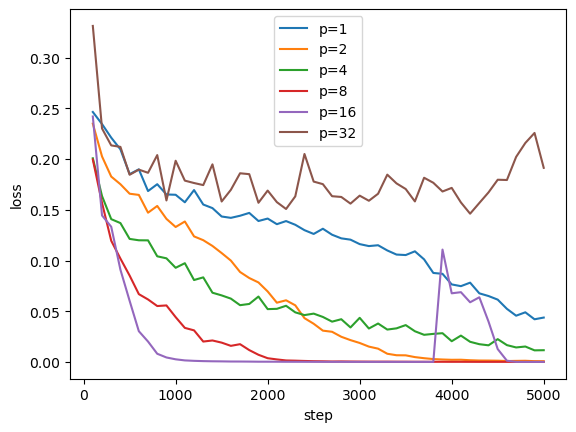

In [12]:
for x, y, p in zip(steps, losses, polarizabilities):
    pl.plot(x, y, label='p='+str(p))
pl.xlabel('step')
pl.ylabel('loss')
pl.legend()
pl.savefig('loss.png')
pl.show()

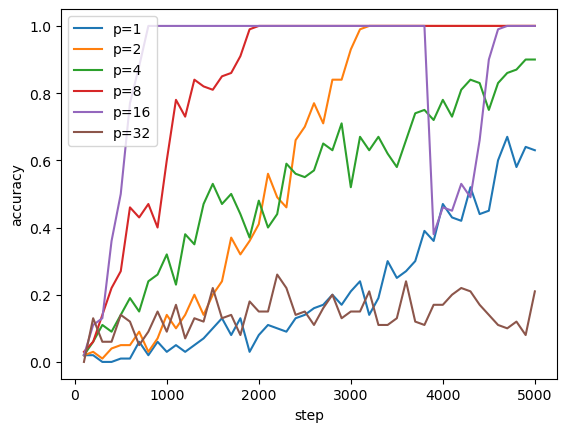

In [13]:
for x, y, p in zip(steps, accuracies, polarizabilities):
    pl.plot(x, y, label='p='+str(p))
pl.xlabel('step')
pl.ylabel('accuracy')
pl.legend()
pl.savefig('accuracy.png')
pl.show()